In [1]:
import json
import pandas as pd
import shapely
from pathlib import Path
import geopandas as gpd
from shapely.geometry import Polygon
from collections import defaultdict
from PIL import Image

In [2]:
labels_path = Path.cwd().parent / "runs/detect/predict3/labels"
frames_path = Path.cwd().parent / "runs/detect/predict3/video_low_fps_frames"

In [3]:
sample = "video_low_fps_10.txt"

df = pd.read_csv(
    labels_path / sample,
    names=["class", "x_center", "y_center", "width", "height", "conf"],
    delimiter=" ",
)
df.head()

,class,x_center,y_center,width,height,conf
0,0,0.354323,0.512495,0.244587,0.790106,0.978191
1,0,0.618346,0.509037,0.236479,0.797263,0.966314
2,2,0.264327,0.215125,0.042515,0.071548,0.965715
3,2,0.263077,0.351598,0.042888,0.073368,0.958167
4,2,0.523762,0.800382,0.040243,0.069390,0.956961


In [4]:
def to_polygon(x):
    return Polygon(
        [
            (x.x_center - x.width / 2, x.y_center - x.height / 2),
            (x.x_center + x.width / 2, x.y_center - x.height / 2),
            (x.x_center + x.width / 2, x.y_center + x.height / 2),
            (x.x_center - x.width / 2, x.y_center + x.height / 2),
        ]
    )


df["geometry"] = df.apply(
    to_polygon,
    axis=1,
)
gdf = gpd.GeoDataFrame(df)

gdf.head()

,class,x_center,y_center,width,height,conf,geometry
0,0,0.354323,0.512495,0.244587,0.790106,0.978191,"POLYGON ((0.23203 0.11744, 0.47662 0.11744, 0...."
1,0,0.618346,0.509037,0.236479,0.797263,0.966314,"POLYGON ((0.50011 0.11041, 0.73659 0.11041, 0...."
2,2,0.264327,0.215125,0.042515,0.071548,0.965715,"POLYGON ((0.24307 0.17935, 0.28558 0.17935, 0...."
3,2,0.263077,0.351598,0.042888,0.073368,0.958167,"POLYGON ((0.24163 0.31491, 0.28452 0.31491, 0...."
4,2,0.523762,0.800382,0.040243,0.069390,0.956961,"POLYGON ((0.50364 0.76569, 0.54388 0.76569, 0...."


In [5]:
gdf.explore()

In [6]:
gdf_boards = gdf[gdf["class"] == 0]
gdf_boards.index.names = ["BoardIndex"]
gdf_boards.head()

,class,x_center,y_center,width,height,conf,geometry
BoardIndex,,,,,,,
0,0,0.354323,0.512495,0.244587,0.790106,0.978191,"POLYGON ((0.23203 0.11744, 0.47662 0.11744, 0...."
1,0,0.618346,0.509037,0.236479,0.797263,0.966314,"POLYGON ((0.50011 0.11041, 0.73659 0.11041, 0...."


In [7]:
gdf_boards = gdf_boards.sort_values(by="x_center").reset_index(drop=True)
gdf_boards.index.names = ["BoardIndex"]
gdf_boards.head()

,class,x_center,y_center,width,height,conf,geometry
BoardIndex,,,,,,,
0,0,0.354323,0.512495,0.244587,0.790106,0.978191,"POLYGON ((0.23203 0.11744, 0.47662 0.11744, 0...."
1,0,0.618346,0.509037,0.236479,0.797263,0.966314,"POLYGON ((0.50011 0.11041, 0.73659 0.11041, 0...."


In [8]:
df = pd.DataFrame({"x": []})
df.sort_values(by="x").reset_index(drop=True)
df.shape

(0, 1)

In [9]:
def apply(row):
    return {
        "class": row["class_object"],
        "conf": row["conf_object"],
        "x_center": (row.x_center_object - row.x_center_board + row.width_board / 2)
        / row.width_board,
        "y_center": (row.y_center_object - row.y_center_board + row.height_board / 2)
        / row.height_board,
        "width": row.width_object / row.width_board,
        "height": row.height_object / row.height_board,
    }


gdf_remapped = (
    gdf_boards.sjoin(gdf, how="inner", lsuffix="board", rsuffix="object").apply(
        lambda x: apply(x), axis="columns", result_type="expand"
    )
).reset_index()

gdf_remapped["geometry"] = gdf_remapped[gdf_remapped["class"] != 0].apply(
    to_polygon, axis="columns"
)
gdf_remapped = gpd.GeoDataFrame(gdf_remapped)
gdf_remapped.head()

,BoardIndex,class,conf,x_center,y_center,width,height,geometry
0,0,2.0,0.847239,0.131571,0.035870,0.175004,0.090804,"POLYGON ((0.04407 -0.00953, 0.21907 -0.00953, ..."
1,0,1.0,0.806245,0.746452,0.113505,0.165594,0.094450,"POLYGON ((0.66366 0.06628, 0.82925 0.06628, 0...."
2,0,2.0,0.965715,0.132049,0.123633,0.173822,0.090555,"POLYGON ((0.04514 0.07836, 0.21896 0.07836, 0...."
3,0,3.0,0.854222,0.455774,0.179749,0.159900,0.374165,"POLYGON ((0.37582 -0.00733, 0.53572 -0.00733, ..."
4,0,3.0,0.290349,0.562996,0.182239,0.187826,0.385475,"POLYGON ((0.46908 -0.0105, 0.65691 -0.0105, 0...."


In [10]:
gdf_remapped[gdf_remapped["BoardIndex"] == 0].explore()

In [11]:
def iou(p1, p2):
    inter = p1.intersection(p2).area
    union = p1.union(p2).area
    return inter / union if union > 0 else 0


def deduplicate_gdf(gdf, iou_threshold: float = 0.8):

    keep = []
    dropped = set()

    for i, geom_i in enumerate(gdf.geometry):
        if i in dropped:
            continue

        keep.append(i)

        for j in range(i + 1, len(gdf)):
            if j in dropped:
                continue
            geom_j = gdf.geometry[j]

            if iou(geom_i, geom_j) > iou_threshold:
                dropped.add(j)

    return gdf.loc[keep].reset_index(drop=True)


board1 = gdf_remapped[
    (gdf_remapped.BoardIndex == 0) & (gdf_remapped["class"].isin([1, 2]))
]

deduplicate_gdf(board1.reset_index(drop=True)).head()

,BoardIndex,class,conf,x_center,y_center,width,height,geometry
0,0,2.0,0.847239,0.131571,0.035870,0.175004,0.090804,"POLYGON ((0.04407 -0.00953, 0.21907 -0.00953, ..."
1,0,1.0,0.806245,0.746452,0.113505,0.165594,0.094450,"POLYGON ((0.66366 0.06628, 0.82925 0.06628, 0...."
2,0,2.0,0.965715,0.132049,0.123633,0.173822,0.090555,"POLYGON ((0.04514 0.07836, 0.21896 0.07836, 0...."
3,0,2.0,0.939068,0.126436,0.210596,0.178369,0.089545,"POLYGON ((0.03725 0.16582, 0.21562 0.16582, 0...."
4,0,2.0,0.958167,0.126938,0.296360,0.175348,0.092859,"POLYGON ((0.03926 0.24993, 0.21461 0.24993, 0...."


In [12]:
def parse_half_board_state(gdf):
    state = {}

    tol = 0.08

    for y_point_index in [0, 1]:
        for h_point_index in range(0, 6):
            h_pos = h_point_index / 6 + (1 / 6 / 2)
            if y_point_index == 0:
                # Lower half
                d = gdf[
                    (gdf["class"].isin([1, 2]))
                    & (gdf.y_center < 0.5)
                    & ((gdf.x_center - h_pos).abs() < tol)
                ].reset_index(drop=True)
                point_index = 6 - h_point_index
            else:
                d = gdf[
                    (gdf["class"].isin([1, 2]))
                    & (gdf.y_center > 0.5)
                    & ((gdf.x_center - h_pos).abs() < tol)
                ].reset_index(drop=True)
                point_index = 12 - h_point_index
            class_index_temp = (
                d.groupby("class")
                .count()
                .reset_index()
                .nlargest(1, "BoardIndex")["class"]
            )

            if class_index_temp.shape[0] == 0:
                class_index = 2
            else:
                class_index = class_index_temp.values[0]

            num_checkers = deduplicate_gdf(d).shape[0]
            val = num_checkers if class_index == 2 else -num_checkers

            state[f"Point_{point_index}"] = val
    return state


state = parse_half_board_state(board1)

In [29]:
def parse_full_board(gdf):

    state_board_1 = parse_half_board_state(gdf[gdf["BoardIndex"] == 0])
    state_board_2 = parse_half_board_state(gdf[gdf["BoardIndex"] == 1])

    full_state = {}
    # merge two states
    for x in range(1, 25):
        if x > 0 and x <= 6:
            full_state[f"Point_{x}"] = state_board_2[f"Point_{x}"]
        elif x > 6 and x <= 12:
            full_state[f"Point_{x}"] = state_board_1[f"Point_{x - 6}"]
        elif x > 12 and x <= 18:
            full_state[f"Point_{x}"] = state_board_1[f"Point_{x - 6}"]
        elif x > 18 and x <= 24:
            full_state[f"Point_{x}"] = state_board_2[f"Point_{x - 12}"]
    return full_state, state_board_1, state_board_2


state, s1, s2 = parse_full_board(gdf_remapped)

In [30]:
state

{'Point_1': 2,
 'Point_2': 0,
 'Point_3': 0,
 'Point_4': 0,
 'Point_5': 0,
 'Point_6': -5,
 'Point_7': 0,
 'Point_8': -3,
 'Point_9': 0,
 'Point_10': 0,
 'Point_11': 0,
 'Point_12': 5,
 'Point_13': -1,
 'Point_14': 3,
 'Point_15': 0,
 'Point_16': 0,
 'Point_17': 0,
 'Point_18': -4,
 'Point_19': -2,
 'Point_20': 0,
 'Point_21': 0,
 'Point_22': 0,
 'Point_23': 0,
 'Point_24': 5}

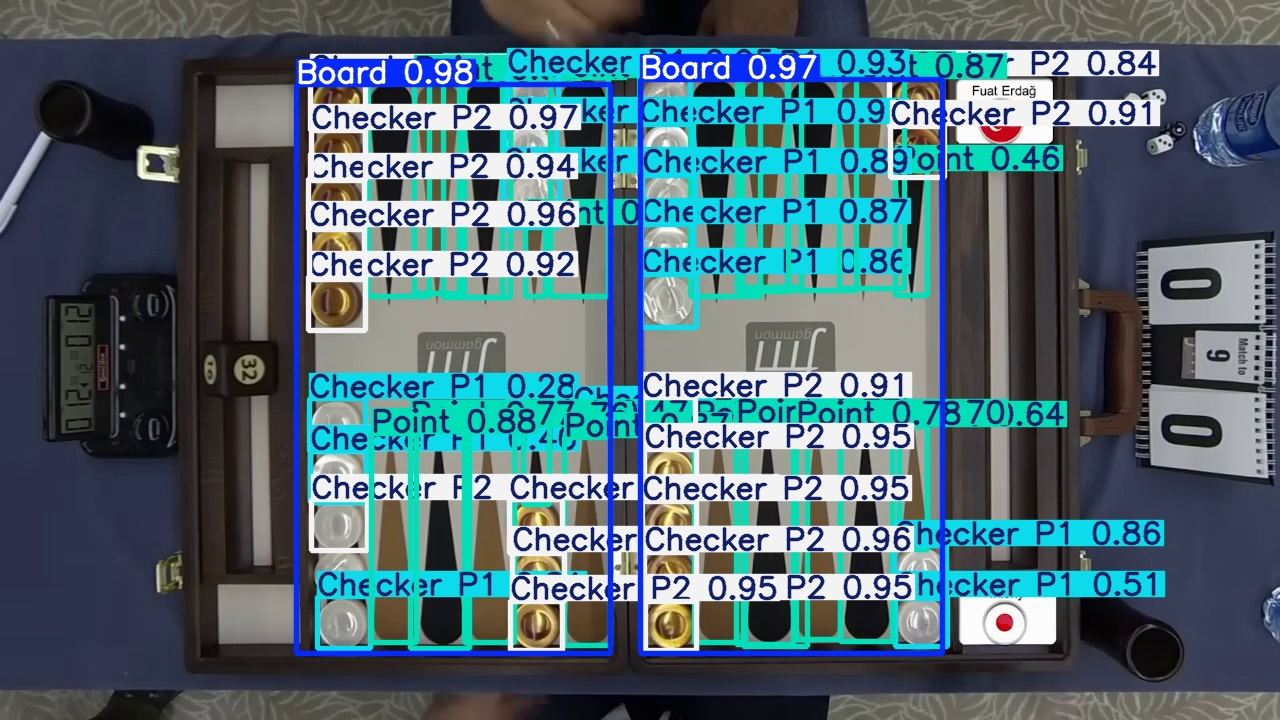

In [15]:
image_path = (frames_path / sample).with_suffix(".jpg")

Image.open(image_path)

In [16]:
import matplotlib.pyplot as plt

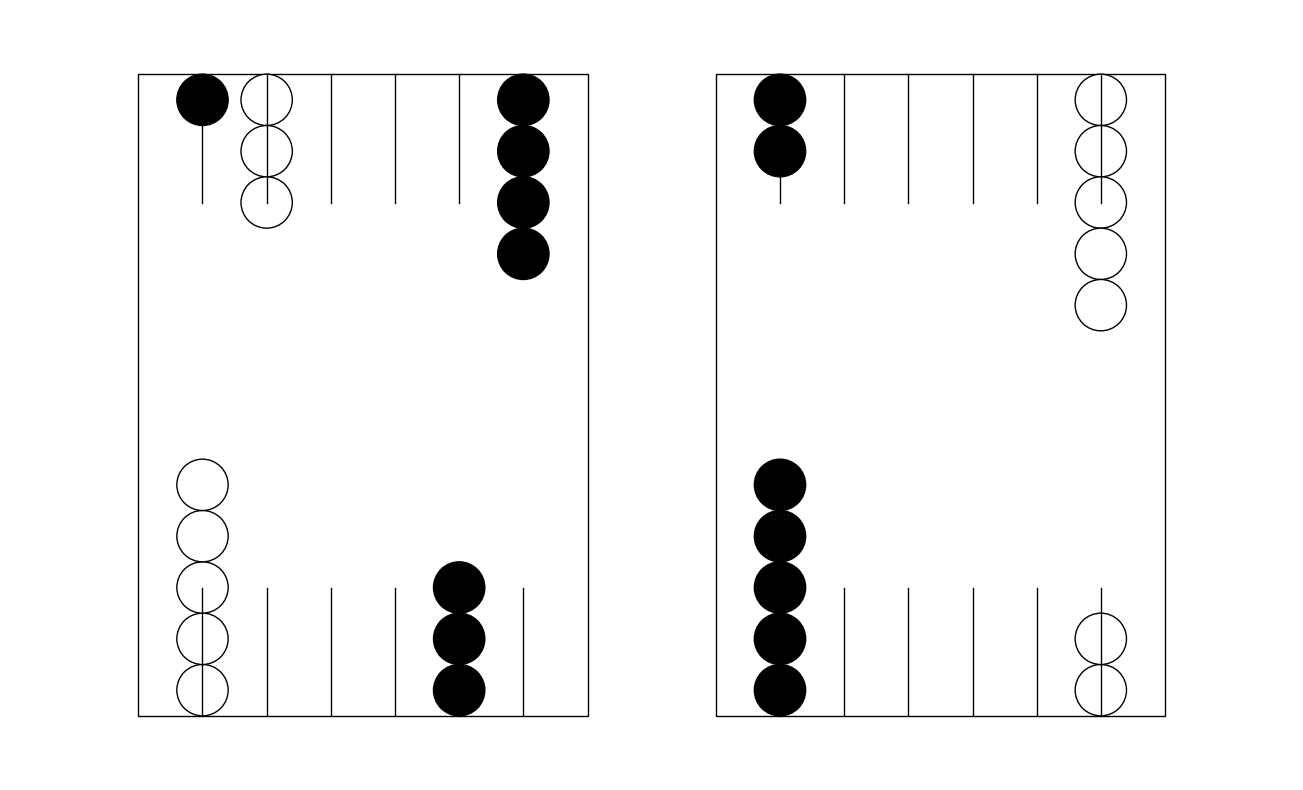

In [54]:
import matplotlib.patches as patches

f, ax = plt.subplots(1, 1, figsize=(16, 8))

left_board = patches.Rectangle(
    (-4.0, -2.5), 3.5, 5, linewidth=1, edgecolor="black", facecolor="none"
)
right_board = patches.Rectangle(
    (0.5, -2.5), 3.5, 5, linewidth=1, edgecolor="black", facecolor="none"
)
ax.add_patch(left_board)
ax.add_patch(right_board)

point_x = {
    **{f"Point_{i}": 3.5 - (i - 1) * 0.5 for i in range(1, 7)},
    **{f"Point_{i}": -1.0 - (i - 7) * 0.5 for i in range(7, 13)},
    **{f"Point_{i}": -3.5 + (i - 13) * 0.5 for i in range(13, 19)},
    **{f"Point_{i}": 1.0 + (i - 19) * 0.5 for i in range(19, 25)},
}

checker_radius = 0.2
max_checkers = 6  # Stack up to 5 checkers for visibility
for point, count in state.items():
    if point not in point_x:
        continue  # Skip if point not in standard 1-24
    x = point_x[point]
    is_top = int(point.split("_")[1]) in range(13, 25)
    y_start = 2.5 if is_top else -2.5
    y_end = 1.5 if is_top else -1.5
    # Draw point line (triangle approximated as a line)
    plt.plot([x, x], [y_start, y_end], color="black", linewidth=1)
    # Draw checkers

    abs_count = abs(count)
    if abs_count > 0:
        color = "white" if count > 0 else "black"  # Player 1: white, Player 2: black
        for i in range(min(abs_count, max_checkers)):
            y = y_start + (-1 if is_top else 1) * (
                i * 2 * checker_radius + checker_radius
            )
            circle = patches.Circle(
                (x, y), checker_radius, facecolor=color, edgecolor="black"
            )
            ax.add_patch(circle)
        # If more than max_checkers, add a text label
        if abs_count > max_checkers:
            y = y_end + (-1 if is_top else 1) * (
                max_checkers * 2 * checker_radius + checker_radius
            )
            plt.text(x, y, str(abs_count), ha="center", va="center", fontsize=8)

ax.set_xlim(-5, 5)
ax.set_ylim(-3, 3)
ax.set_aspect("equal")
ax.axis("off")

# Save and show
plt.tight_layout()
plt.savefig("backgammon_board.jpg", dpi=300, bbox_inches="tight")
plt.show()

In [36]:
state

{'Point_1': 2,
 'Point_2': 0,
 'Point_3': 0,
 'Point_4': 0,
 'Point_5': 0,
 'Point_6': -5,
 'Point_7': 0,
 'Point_8': -3,
 'Point_9': 0,
 'Point_10': 0,
 'Point_11': 0,
 'Point_12': 5,
 'Point_13': -1,
 'Point_14': 3,
 'Point_15': 0,
 'Point_16': 0,
 'Point_17': 0,
 'Point_18': -4,
 'Point_19': -2,
 'Point_20': 0,
 'Point_21': 0,
 'Point_22': 0,
 'Point_23': 0,
 'Point_24': 5}

In [42]:
point_x

{'Point_1': 6.5,
 'Point_2': 6.0,
 'Point_3': 5.5,
 'Point_4': 5.0,
 'Point_5': 4.5,
 'Point_6': 4.0,
 'Point_7': -0.5,
 'Point_8': -1.0,
 'Point_9': -1.5,
 'Point_10': -2.0,
 'Point_11': -2.5,
 'Point_12': -3.0,
 'Point_13': -3.5,
 'Point_14': -3.0,
 'Point_15': -2.5,
 'Point_16': -2.0,
 'Point_17': -1.5,
 'Point_18': -1.0,
 'Point_19': 0.5,
 'Point_20': 1.0,
 'Point_21': 1.5,
 'Point_22': 2.0,
 'Point_23': 2.5,
 'Point_24': 3.0}